# Chapter 19 
 Machine Learning for Business Analytics<br>
Concepts, Techniques, and Applications in Python<br>
by Galit Shmueli, Peter C. Bruce, Peter Gedeck, Nitin R. Patel

Publisher: Wiley; 2nd edition (2024) <br>
<!-- ISBN-13: 978-3031075650 -->

(c) 2024 Galit Shmueli, Peter C. Bruce, Peter Gedeck, Nitin R. Patel

The code needs to be executed in sequence.

Python packages and Python itself change over time. This can cause warnings or errors.
"Warnings" are for information only and can usually be ignored.
"Errors" will stop execution and need to be fixed in order to get results.

If you come across an issue with the code, please follow these steps

- Check the repository (https://gedeck.github.io/sdsa-code-solutions/) to see if the code has been upgraded. This might solve the problem.
- Report the problem using the issue tracker at https://github.com/gedeck/sdsa-code-solutions/issues
- Paste the error message into Google and see if someone else already found a solution

In [2]:
import pprint

import keras
import matplotlib.pyplot as plt
import mlba
import pandas as pd
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.pipeline import make_pipeline
from sktime.split import temporal_train_test_split
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.utils.plotting import plot_series
%matplotlib inline

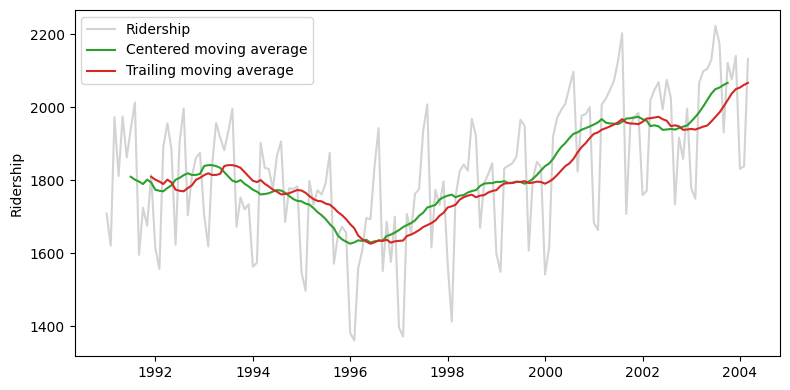

In [3]:
# load data and convert to time series
Amtrak_df = mlba.load_data('Amtrak.csv')
Amtrak_df['Date'] = pd.to_datetime(Amtrak_df.Month, format='%d/%m/%Y')
ridership_ts = pd.Series(Amtrak_df.Ridership.values, index=Amtrak_df.Date,
                          name='Ridership')
ridership_ts = ridership_ts.to_period('M')

# centered moving average with window size = 12
centered_ma = WindowSummarizer(lag_feature={'mean': [[-5, 12]]})
centered_ma.fit(ridership_ts)

# trailing moving average with window size = 12
trailing_ma = WindowSummarizer(lag_feature={'mean': [[0, 12]]})
trailing_ma.fit(ridership_ts)

fig, ax = plt.subplots(figsize=(8, 4))
plot_series(ridership_ts,
            centered_ma.transform(ridership_ts),
            trailing_ma.transform(ridership_ts),
            labels=['Ridership', 'Centered moving average', 'Trailing moving average'],
            colors=['lightgrey', 'C2', 'C3'], markers=['', '', ''], ax=ax,
)
plt.tight_layout()
plt.show()

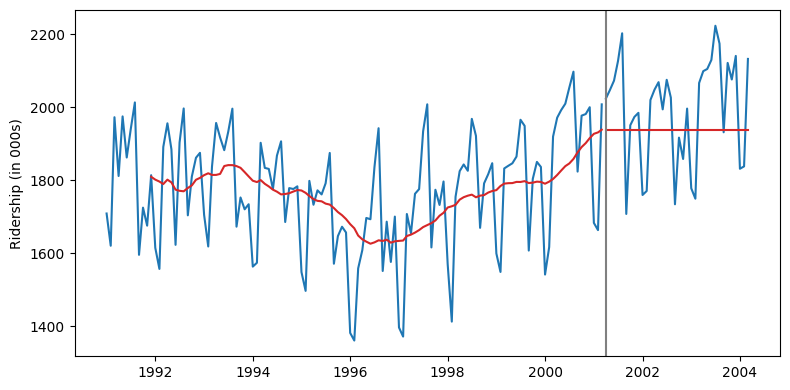

In [4]:
# partition the data
nHoldout = 36
train_ts, holdout_ts = temporal_train_test_split(ridership_ts, test_size=nHoldout)

# moving average on training
trailing_ma = WindowSummarizer(lag_feature={'mean': [[0, 12]]})

ma_trailing = trailing_ma.fit_transform(train_ts)
last_ma = ma_trailing.iloc[-1]

# create forecast based on last moving average in the training period
ma_trailing_pred = pd.Series(last_ma, index=holdout_ts.index)

fig, ax = plt.subplots(figsize=(8, 4))
plot_series(train_ts, holdout_ts, ma_trailing, ma_trailing_pred,
    ax=ax, y_label='Ridership (in 000s)',
    colors=['C0', 'C0', 'C3', 'C3'], markers=['', '', '', ''])
ax.axvline(train_ts.index[-1], color='grey')
plt.tight_layout()
plt.show()

In [5]:
# Build a model with seasonality, trend, and quadratic trend
forecaster_season = make_pipeline(
    Deseasonalizer(sp=12),
    PolynomialTrendForecaster(degree=2),
)
forecaster_season.fit(train_ts)

# create single-point forecast
ridership_prediction = forecaster_season.predict(fh=1)

# apply MA to residuals
residuals = forecaster_season.predict_residuals(train_ts)
ma_trailing = trailing_ma.transform(residuals)

# ridership_prediction
print(f'Prediction {ridership_prediction.iloc[0]}')
print(f'ma_trailing {ma_trailing.iloc[-1]}')

Prediction 2015.5724239380988
ma_trailing 30.66001159199713


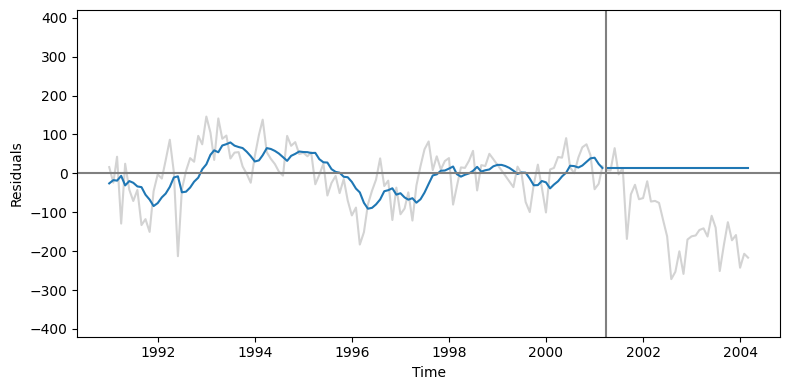

In [6]:
residuals_train = forecaster_season.predict_residuals(train_ts)
residuals_holdout = forecaster_season.predict_residuals(holdout_ts)

# run exponential smoothing
exp_smoothing = ExponentialSmoothing(smoothing_level=0.2, sp=12)
exp_smoothing.fit(residuals_train)

fig, ax = plt.subplots(figsize=(8, 4))
plot_series(residuals_train, residuals_holdout,
    exp_smoothing.predict(residuals_train.index),
    exp_smoothing.predict(residuals_holdout.index),
    x_label='Time', y_label='Residuals', ax=ax,
    colors=['lightgrey', 'lightgrey', 'C0', 'C0'], markers=['', '', '', ''])
ax.axhline(0, color='grey')
ax.axvline(train_ts.index[-1], color='grey')
ax.set_ylim(-420, 420)
plt.tight_layout()
plt.show()

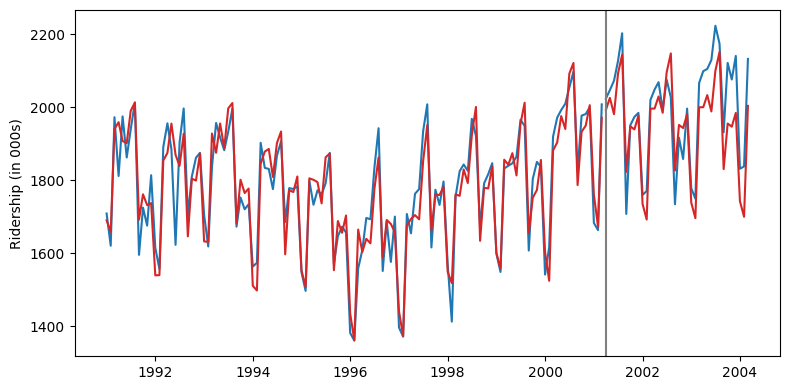

In [7]:
# run exponential smoothing with additive trend and additive seasonal
expSmooth = ExponentialSmoothing(trend='additive', seasonal='additive', sp=12)
expSmoothFit = expSmooth.fit(train_ts)

fig, ax = plt.subplots(figsize=(8, 4))
plot_series(train_ts, holdout_ts,
    expSmoothFit.predict(train_ts.index),
    expSmoothFit.predict(holdout_ts.index),
    ax=ax, y_label='Ridership (in 000s)',
    colors=['C0', 'C0', 'C3', 'C3'], markers=['', '', '', ''])
ax.axvline(train_ts.index[-1], color='grey')
plt.tight_layout()
plt.show()

In [8]:
pprint.pprint(expSmoothFit._fitted_forecaster.params)
pd.DataFrame({
    'Training': mlba.regressionMetrics(y_true=train_ts, y_pred=expSmoothFit.predict(train_ts.index)),
    'Holdout': mlba.regressionMetrics(y_true=holdout_ts, y_pred=expSmoothFit.predict(holdout_ts.index)),
}).round(3).transpose()

{'damping_trend': nan,
 'initial_level': 1894.160481898073,
 'initial_seasons': array([-204.1684555 , -247.16308524,   56.36156898,   56.16292236,
         88.96581747,   43.88300671,  155.10052728,  206.00459269,
       -115.04060651,    9.46693148,    0.62574466,   37.99888465]),
 'initial_trend': 0.31559623411256155,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.5751645821874132,
 'smoothing_seasonal': 0.002289901852857784,
 'smoothing_trend': 0.0,
 'use_boxcox': False}


,ME,RMSE,MAE,MPE,MAPE
Training,0.044,55.924,44.198,-0.076,2.518
Holdout,43.915,84.101,69.988,2.100,3.513


In [9]:
# define function for normalization of training set and it's inverse
minmax = (train_ts.min(), train_ts.max())
normalize_ts = lambda x: (x - minmax[0]) / (minmax[1] - minmax[0])
inv_normalize_ts = lambda x: x * (minmax[1] - minmax[0]) + minmax[0]
norm_train_ts = normalize_ts(train_ts)

# convert timeseries into sequence of subseries of length (ninput + noutput)
ninput = 12
noutput = 1
nSubsequences = len(norm_train_ts) - (ninput + noutput) + 1
getSubsequence = lambda i: norm_train_ts[i:(i + ninput + noutput)]
train = pd.DataFrame([list(getSubsequence(i)) for i in range(nSubsequences)],
             columns=[*[f'x{i}' for i in range(1, ninput + noutput)], 'y'])
train_X = train.iloc[:,:-1].to_numpy().reshape(-1, ninput, 1)
train_y = train.iloc[:,-1].to_numpy().reshape(-1, 1)
train_X.shape, train_y.shape

((111, 12, 1), (111, 1))

In [10]:
input_shape = train_X.shape[1:]
model = keras.Sequential([
    keras.Input(input_shape),
    keras.layers.LSTM(50, # size of the layer
                      dropout=0.01,
                      recurrent_dropout=0.01,
                      return_sequences=True,
    ),
    keras.layers.LSTM(50,
                      return_sequences=True,
    ),
    keras.layers.Flatten(),
    keras.layers.Dense(1),
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 12, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           601 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,201 (121.88 KB)

 Trainable params: 31,201 (121.88 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

In [12]:
history = model.fit(train_X, train_y, epochs=400, shuffle=True,
                    batch_size=len(train_X), verbose=2)

Epoch 1/400
1/1 - 1s - 1s/step - loss: 0.3283 - mean_squared_error: 0.3283
Epoch 2/400
1/1 - 0s - 20ms/step - loss: 0.2860 - mean_squared_error: 0.2860
Epoch 3/400
1/1 - 0s - 27ms/step - loss: 0.2455 - mean_squared_error: 0.2455
Epoch 4/400
1/1 - 0s - 28ms/step - loss: 0.2047 - mean_squared_error: 0.2047
Epoch 5/400
1/1 - 0s - 26ms/step - loss: 0.1651 - mean_squared_error: 0.1651
Epoch 6/400
1/1 - 0s - 38ms/step - loss: 0.1322 - mean_squared_error: 0.1322
Epoch 7/400
1/1 - 0s - 18ms/step - loss: 0.0941 - mean_squared_error: 0.0941
Epoch 8/400
1/1 - 0s - 39ms/step - loss: 0.0691 - mean_squared_error: 0.0691
Epoch 9/400
1/1 - 0s - 21ms/step - loss: 0.0466 - mean_squared_error: 0.0466
Epoch 10/400
1/1 - 0s - 39ms/step - loss: 0.0434 - mean_squared_error: 0.0434
Epoch 11/400
1/1 - 0s - 20ms/step - loss: 0.0525 - mean_squared_error: 0.0525
Epoch 12/400
1/1 - 0s - 31ms/step - loss: 0.0666 - mean_squared_error: 0.0666
Epoch 13/400
1/1 - 0s - 21ms/step - loss: 0.0786 - mean_squared_error: 0.07

Text(0, 0.5, 'Mean Squared Error')

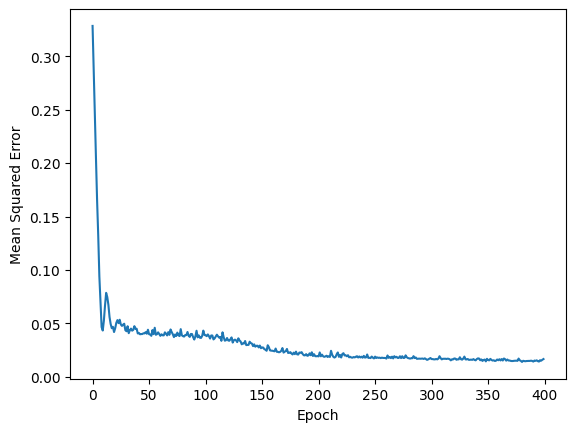

In [13]:
ax = pd.DataFrame(history.history)['mean_squared_error'].plot()
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Squared Error')

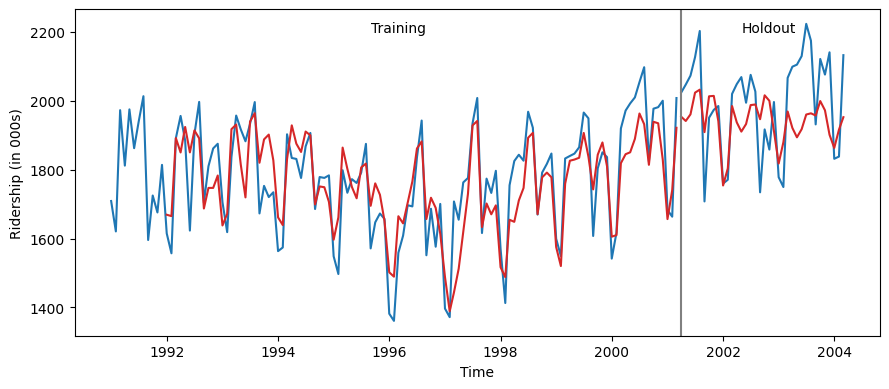

In [14]:
import numpy as np
# convert timeseries into sequence of subseries of length (ninput + noutput)
window = norm_train_ts[-ninput:].to_numpy()
forecast = []
for _ in range(nHoldout):
    forecast.append(model.predict(window.reshape(1, ninput, 1), verbose=0)[0][0])
    window = np.append(window[1:], forecast[-1])
forecast = inv_normalize_ts(np.array(forecast))
forecast = pd.Series(forecast, index=holdout_ts.index)

pred_train = pd.Series(inv_normalize_ts(model.predict(train_X, verbose=0).flat),
                       index=train_ts.index[ninput:])

fig, ax = plt.subplots(figsize=(9, 4))
plot_series(train_ts, holdout_ts, pred_train, forecast,
            x_label='Time', y_label='Ridership (in 000s)',
            # labels=['Ridership', '', 'Forecast'],
            colors=['C0', 'C0', 'C3', 'C3'],
            markers=['', '', '', ''], ax=ax)
ax.axvline(train_ts.index[-1], color='grey')
ax.text(train_ts.index[len(train_ts) // 2], 2200, "Training", horizontalalignment='center')
ax.text(holdout_ts.index[len(holdout_ts) // 2], 2200, "Holdout", horizontalalignment='center')
plt.tight_layout()
plt.show()

In [15]:
pd.DataFrame({
    'Training': mlba.regressionMetrics(y_true=train_ts[ninput:], y_pred=pred_train),
    'Holdout': mlba.regressionMetrics(y_true=holdout_ts, y_pred=forecast),
}).round(3).transpose()

,ME,RMSE,MAE,MPE,MAPE
Training,9.195,89.036,72.559,0.240,4.16
Holdout,53.066,133.048,113.907,2.267,5.65
